# **LSTM - MODELS IMDb Dataset**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Cek apakah CUDA tersedia dan gunakan GPU jika memungkinkan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **PYTORCH**

In [3]:
# Load IMDb Dataset
num_words = 30000  # Set the max number of words for the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Pad the sequences to a fixed length
maxlen = 300
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [5]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

In [6]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, (hn, cn) = self.lstm(x)
        out = hn[-1]  # Take the last hidden state from the LSTM
        out = self.fc1(out)
        out = self.fc2(out)
        return self.sigmoid(out)

In [7]:
# Hyperparameters
input_dim = num_words  # Number of words in vocabulary
hidden_dim = 64  # Hidden layer dimensions
output_dim = 1  # Binary classification

In [8]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training loop
num_epochs = 5
batch_size = 32
train_loader = DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=batch_size, shuffle=True)

In [10]:

# Track loss and accuracy for plotting
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions
        preds = outputs.squeeze().round()  # Round to get 0 or 1
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    train_loss.append(epoch_loss)
    train_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/5, Loss: 0.5538, Accuracy: 0.7054
Epoch 2/5, Loss: 0.4367, Accuracy: 0.7962
Epoch 3/5, Loss: 0.2937, Accuracy: 0.8802
Epoch 4/5, Loss: 0.2372, Accuracy: 0.9092
Epoch 5/5, Loss: 0.1566, Accuracy: 0.9419


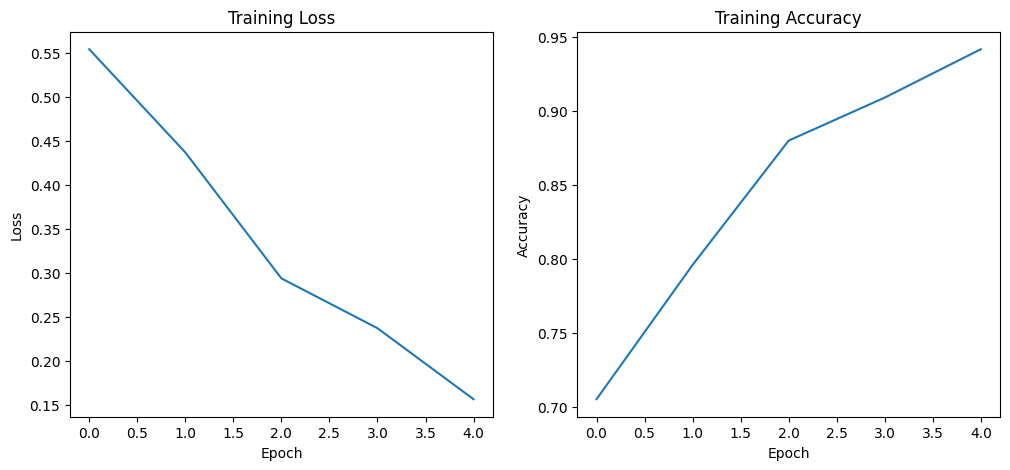

In [11]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [12]:
# Evaluate the model on test data
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in DataLoader(list(zip(x_test_tensor, y_test_tensor)), batch_size=batch_size):
        outputs = model(inputs)
        probs = outputs.squeeze().cpu().numpy()
        preds = np.round(probs)
        all_probs.extend(probs)
        all_preds.extend(preds)

In [13]:
accuracy = accuracy_score(y_test, all_preds)
precision = precision_score(y_test, all_preds)
recall = recall_score(y_test, all_preds)
f1 = f1_score(y_test, all_preds)
auc = roc_auc_score(y_test, all_probs)

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

Test Accuracy: 0.8380
Test Precision: 0.8521
Test Recall: 0.8179
Test F1 Score: 0.8347
Test AUC: 0.9141


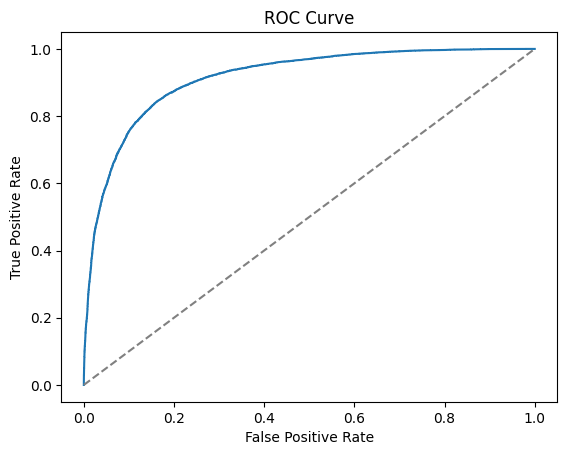

In [14]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, all_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# **TENSORFLOW**

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [17]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [18]:
# Define the model (LSTM Model)
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(128, dropout=0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.7091 - loss: 0.5315 - val_accuracy: 0.8510 - val_loss: 0.3524
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9059 - loss: 0.2461 - val_accuracy: 0.7081 - val_loss: 0.6023
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8655 - loss: 0.3201 - val_accuracy: 0.8586 - val_loss: 0.3785
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9588 - loss: 0.1226 - val_accuracy: 0.8412 - val_loss: 0.4838
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9689 - loss: 0.0934 - val_accuracy: 0.8554 - val_loss: 0.4998


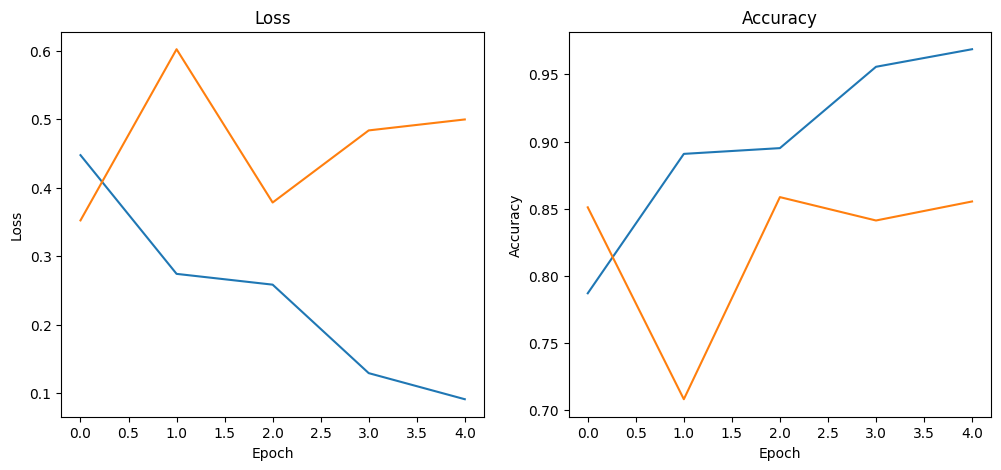

In [21]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [22]:
# Evaluate the model on test data
y_pred = (model.predict(x_test) > 0.5).astype('int32')

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


In [23]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

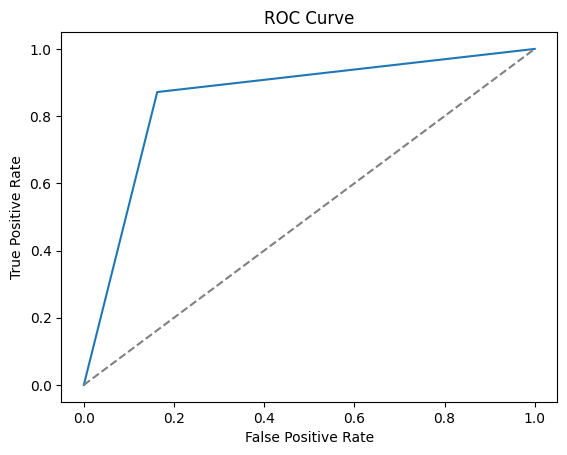

Test Accuracy: 0.8544
Test Precision: 0.8426
Test Recall: 0.8717
Test F1 Score: 0.8569
Test AUC: 0.8544


In [24]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

# **Analisis Proyek LSTM Model untuk Klasifikasi Sentimen pada Dataset IMDb**

Pada proyek ini, menggunakan LSTM (Long Short-Term Memory) untuk menganalisis sentimen dari dataset IMDb, yang berisi ulasan film. Model ini digunakan untuk mengklasifikasikan ulasan menjadi dua kategori: Positif atau Negatif. Kita telah mengimplementasikan model ini menggunakan dua framework deep learning, yaitu PyTorch dan TensorFlow, dan mengevaluasinya dengan berbagai metrik.

Berikut adalah hasil evaluasi yang diperoleh dari pengujian model:

#### **Hasil PyTorch**
- **Test Accuracy**: 0.8380
- **Test Precision**: 0.8521
- **Test Recall**: 0.8179
- **Test F1 Score**: 0.8347
- **Test AUC**: 0.9141

#### **Hasil TensorFlow**
- **Test Accuracy**: 0.8544
- **Test Precision**: 0.8426
- **Test Recall**: 0.8717
- **Test F1 Score**: 0.8569
- **Test AUC**: 0.8544

#### **1. Penjelasan untuk Metrik Evaluasi**

Setiap metrik yang digunakan dalam evaluasi model memberikan informasi penting tentang performa model. Berikut adalah penjelasan masing-masing metrik yang digunakan:

---

### **Akurasi (Accuracy)**

Akurasi mengukur persentase prediksi yang benar dari total prediksi yang dilakukan oleh model. Ini adalah metrik yang sangat umum digunakan dalam klasifikasi, tetapi bisa jadi tidak representatif jika dataset tidak seimbang (misalnya jumlah data positif dan negatif sangat berbeda).


$$\text{Accuracy} = \frac{\text{Jumlah Prediksi yang Benar}}{\text{Jumlah Total Prediksi}}$$


#### **Interpretasi:**
- Test Accuracy (PyTorch): 0.8380 berarti 83.80% dari prediksi yang dilakukan oleh model benar.
- Test Accuracy (TensorFlow): 0.8544 berarti 85.44% dari prediksi yang dilakukan oleh model benar.

Hasil ini menunjukkan bahwa model cukup baik dalam mengklasifikasikan ulasan menjadi dua kategori, tetapi ada ruang untuk perbaikan.

---

### **Presisi (Precision)**

Presisi mengukur seberapa banyak dari semua prediksi positif yang benar-benar positif. Ini sangat penting ketika kita ingin menghindari prediksi positif palsu yang banyak.


$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

#### **Interpretasi:**
- Test Precision (PyTorch): 0.8521 berarti 85.21% dari semua prediksi positif yang dilakukan oleh model adalah benar.
- Test Precision (TensorFlow): 0.8426 berarti 84.26% dari semua prediksi positif yang dilakukan oleh model adalah benar.

Dengan demikian, model menunjukkan presisi yang cukup tinggi dalam mengklasifikasikan ulasan sebagai positif.

---

### **Recall (Sensitivity)**

Recall mengukur seberapa banyak dari semua data positif yang dapat diprediksi dengan benar oleh model. Ini penting ketika kita ingin memastikan bahwa kita tidak melewatkan banyak contoh positif.


$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$


#### **Interpretasi:**
- Test Recall (PyTorch): 0.8179 berarti model berhasil mendeteksi 81.79% dari semua ulasan positif yang ada dalam dataset.
- Test Recall (TensorFlow): 0.8717 berarti model berhasil mendeteksi 87.17% dari semua ulasan positif yang ada dalam dataset.

Recall yang lebih tinggi di TensorFlow menunjukkan bahwa model lebih baik dalam mendeteksi ulasan positif dibandingkan dengan model PyTorch.

---

### **F1 Score**

F1 Score adalah rata-rata harmonis dari presisi dan recall. Ini adalah metrik yang sangat berguna ketika kita memiliki data yang tidak seimbang (misalnya lebih banyak ulasan negatif daripada positif). F1 memberikan gambaran yang lebih seimbang antara presisi dan recall.


$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$


#### **Interpretasi:**
- Test F1 Score (PyTorch): 0.8347 menunjukkan keseimbangan antara presisi dan recall untuk model PyTorch.
- Test F1 Score (TensorFlow): 0.8569 menunjukkan keseimbangan yang lebih baik antara presisi dan recall untuk model TensorFlow.

Hasil ini menunjukkan bahwa model TensorFlow memberikan keseimbangan yang lebih baik antara presisi dan recall dibandingkan dengan model PyTorch.

---

### **AUC (Area Under the Curve)**

AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). Kurva ROC adalah plot yang menunjukkan seberapa baik model dapat membedakan antara kelas positif dan negatif. AUC adalah skor yang menunjukkan performa keseluruhan model. AUC yang lebih tinggi menunjukkan model yang lebih baik dalam membedakan antara dua kelas.


$$\text{AUC} = \text{Area di bawah kurva ROC}$$


#### **Interpretasi:**
- Test AUC (PyTorch): 0.9141 berarti model PyTorch memiliki kemampuan yang sangat baik untuk membedakan antara ulasan positif dan negatif, dengan area di bawah kurva yang mendekati 1.
- Test AUC (TensorFlow): 0.8544 berarti model TensorFlow juga menunjukkan performa yang sangat baik, meskipun sedikit lebih rendah dibandingkan dengan model PyTorch.

AUC yang tinggi menunjukkan bahwa model dapat dengan efektif membedakan antara ulasan positif dan negatif.

---

### **Kesimpulan**

Berdasarkan hasil evaluasi di atas, berikut adalah beberapa poin penting yang dapat disimpulkan:

1. **Performa Model**: Kedua model (PyTorch dan TensorFlow) menunjukkan hasil yang baik dengan akurasi di atas 80%. TensorFlow sedikit lebih unggul dalam hal recall dan F1 score, menunjukkan bahwa model TensorFlow lebih baik dalam mendeteksi ulasan positif dan mencapai keseimbangan antara presisi dan recall.
   
2. **Tuning dan Performa**: Model TensorFlow memiliki sedikit keunggulan dalam hal recall dan F1, yang dapat disebabkan oleh perbedaan dalam implementasi atau pengaturan hyperparameter. Oleh karena itu, jika prioritas utama adalah mendeteksi ulasan positif dengan lebih baik, model TensorFlow mungkin lebih disarankan.

3. **AUC**: Kedua model memiliki AUC yang sangat baik, yang menunjukkan bahwa keduanya mampu membedakan antara ulasan positif dan negatif dengan sangat baik. PyTorch sedikit lebih unggul dalam hal AUC, tetapi perbedaannya sangat kecil.

4. **Keseimbangan Precision-Recall**: Model TensorFlow sedikit lebih baik dalam mencapai keseimbangan antara presisi dan recall, yang berarti lebih sedikit kasus ulasan positif yang terlewatkan.